In [1]:
import pandas as pd
import re
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read the list of filenames from the configuration file
with open('../file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = f"../data/{file}"
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])
data['date'] = pd.to_datetime(data['date'])

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

data["user"] = data["user"].replace("Banties1g", "banties_x")
data["user"] = data["user"].replace("banties1g", "banties_x")
data["user"] = data["user"].replace("chili_poe", "chili_con_bacon")
data["user"] = data["user"].replace("CHILI_POE", "chili_con_bacon")
data["user"] = data["user"].replace("chili_conbacon", "chili_con_bacon")
data["user"] = data["user"].replace("Wirelesss_", "W1r3lesss")
data["user"] = data["user"].replace("treklul", "trek44_")
data["user"] = data["user"].replace("ttrek_", "trek44_")
data["user"] = data["user"].replace("trek_x", "trek44_")
data["user"] = data["user"].replace("TriplesingleJ", "TripleSingleJames")
data["user"] = data["user"].replace("uuccugr", "uwu_cougar")
data["user"] = data["user"].replace("uuccugr", "uuccugr_")
data["user"] = data["user"].replace("StanIV4_", "stan_iv4")


In [3]:
from collections import defaultdict

# Get all unique usernames
unique_users = data['user'].unique()

# Create a mapping from lowercase username to all variants

user_variants = defaultdict(set)
for user in unique_users:
    user_variants[user.lower()].add(user)

# Find usernames with different capitalization
duplicate_users = {k: v for k, v in user_variants.items() if len(v) > 1}
"""
# Display the results
for lower, variants in duplicate_users.items():
    print(f"{lower}: {sorted(variants)}")
"""

'\n# Display the results\nfor lower, variants in duplicate_users.items():\n    print(f"{lower}: {sorted(variants)}")\n'

In [4]:
# Create a mapping from all variants to the canonical (sorted first) variant
variant_map = {}
for variants in duplicate_users.values():
    sorted_variants = sorted(variants)
    canonical = sorted_variants[0]
    for v in variants:
        variant_map[v] = canonical

# Replace usernames in 'user' column
data['user'] = data['user'].apply(lambda u: variant_map.get(u, u))

In [5]:
# Find the first stream where each user sent a message
first_stream_df = data.groupby("user")["stream"].min().reset_index()
first_stream_df.rename(columns={"stream": "first_stream"}, inplace=True)

In [6]:
# Merge with the original DataFrame
data = data.merge(first_stream_df, on="user", how="left")
data.tail(10)

,date,user,message,stream,first_stream
2887697,2025-11-26 17:51:09 UTC,StreamElements,Wanna see past VODs? Go sub to the VODs Chann...,481,0
2887698,2025-11-26 17:51:09 UTC,KRIESEAX,Adeos,481,254
2887699,2025-11-26 17:51:09 UTC,sgc136,:D,481,480
2887700,2025-11-26 17:51:11 UTC,MyLastTwitchAccount,bye bye,481,161
2887701,2025-11-26 17:51:12 UTC,lajosbarnabas,bye bye,481,0
2887702,2025-11-26 17:51:14 UTC,Lyvione,WW stream,481,477
2887703,2025-11-26 17:51:14 UTC,rafa30___,GhankYou,481,276
2887704,2025-11-26 17:51:15 UTC,sgc136,bye bye,481,480
2887705,2025-11-26 17:51:15 UTC,HALP____,bye bye,481,375
2887706,2025-11-26 17:51:30 UTC,shogalul,o7,481,130


In [7]:
# Count occurrences of first_stream for each stream
pivot_table = data.groupby(["stream", "first_stream"]).size().unstack(fill_value=0)

# Reset index for better readability
pivot_table = pivot_table.reset_index()

In [8]:
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Columns: 483 entries, stream to 481
dtypes: int64(483)
memory usage: 1.8 MB


In [9]:
pivot_table = pivot_table.drop(columns=['stream'])

In [10]:
pivot_table

first_stream,0,1,2,3,4,5,6,7,8,9,...,472,473,474,475,476,477,478,479,480,481
0,1985,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2105,941,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2150,204,400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1788,87,103,397,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1842,87,102,80,344,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,833,83,1,0,0,122,0,2,31,11,...,21,21,48,33,48,463,0,0,0,0
478,841,10,0,0,0,270,6,1,36,52,...,1,10,18,19,66,21,345,0,0,0
479,1052,54,8,0,0,148,1,59,3,40,...,37,47,17,49,66,200,215,512,0,0
480,1214,8,6,0,0,458,0,26,6,57,...,7,32,23,105,278,64,144,85,417,0


In [11]:


# Ensure 'date' column is datetime
data['date'] = pd.to_datetime(data['date'])

# --- FIX START ---

# 1. Sort data by date to ensure 'first()' reliably gets the earliest date
data_sorted = data.sort_values('date')

# 2. Find the actual *first date* for each stream
stream_start_dates = data_sorted.groupby('stream')['date'].first()

# 3. Get the starting period (Year-Month) for each stream
stream_start_periods = stream_start_dates.dt.to_period('M') # 'M' for monthly period

# --- FIX END ---

# Define base colors for each month (1-12) - This remains the same
base_color_map = {
    1: '#008B8B',   
    2: '#FF8C00',   
    3: '#006400',   
    4: '#8B0000',   
    5: '#450145',   
    6: '#00008B',   
    7: '#808000',   
    8: "#005F64",   
    9: '#8B4513',   
    10: "#5102a1",  
    11: '#242323',  
    12: "#9F166D"   
}

# Function to generate shades (unchanged)
def generate_shades(base_color, n_shades, lightness_factor=0.9):
    """Generates lighter shades of a base color."""
    try:
        color_rgba = mcolors.to_rgba(base_color)
        # Create a lighter version by interpolating towards white (or a lighter fixed color)
        # This version interpolates towards white, adjusting alpha if needed
        # A simpler approach might just increase lightness in HSL space
        hsv = mcolors.rgb_to_hsv(color_rgba[:3])
        lighter_hsv = hsv.copy()
        lighter_hsv[2] = 1.0 - (1.0 - hsv[2]) * (1.0 - lightness_factor) # Adjust Value (brightness)
        lighter_rgb = mcolors.hsv_to_rgb(lighter_hsv)

        # Ensure alpha remains the same if it wasn't 1
        light_color_rgba = (*lighter_rgb, color_rgba[3])

        cmap = mcolors.LinearSegmentedColormap.from_list(
            f'shades_of_{mcolors.to_hex(base_color, keep_alpha=True)}',
             [color_rgba, light_color_rgba], N=n_shades
        )
        return [mcolors.to_hex(cmap(i), keep_alpha=True) for i in range(n_shades)] # Return hex for wider compatibility
    except ValueError:
         # Handle cases where base_color might be invalid, though map should prevent this
         print(f"Warning: Could not process base color '{base_color}'. Using gray.")
         gray_color = mcolors.to_rgba("gray")
         light_gray = mcolors.to_rgba("lightgray")
         cmap = mcolors.LinearSegmentedColormap.from_list('shades_of_gray', [gray_color, light_gray], N=n_shades)
         return [mcolors.to_hex(cmap(i), keep_alpha=True) for i in range(n_shades)]


# --- REVISED COLOR MAPPING LOGIC ---

color_list = []
# Iterate through unique *start periods* (Year-Month)
for period in sorted(stream_start_periods.unique()): # Sort periods for consistency
    # Find streams that started in this specific period
    period_streams = stream_start_periods[stream_start_periods == period].index
    n_streams_in_period = len(period_streams)

    # Get the base color using the *month* of the period
    month_num = period.month
    base_color = base_color_map.get(month_num, "#808080") # Default gray if month somehow invalid

    # Generate shades for streams starting in *this specific period*
    # Ensure at least one shade even if n_streams_in_period is 1
    shades = generate_shades(base_color, max(n_streams_in_period, 1))

    # Assign shades to streams
    for i, stream in enumerate(period_streams):
         # Handle potential edge case where generate_shades might return fewer shades than expected
         shade_index = min(i, len(shades) - 1)
         color_list.append((stream, shades[shade_index]))


# Convert to dictionary for easy lookup
color_dict = dict(color_list)

# Ensure colors match pivot table index (assuming pivot_table exists and its index is 'stream')
# Handle streams potentially missing from the data used for color generation
sorted_color_list = [color_dict.get(stream, "#808080") for stream in pivot_table.index] # Use default color for missing streams


C:\Users\Kardo\AppData\Local\Temp\ipykernel_1404\1740638162.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  stream_start_periods = stream_start_dates.dt.to_period('M') # 'M' for monthly period


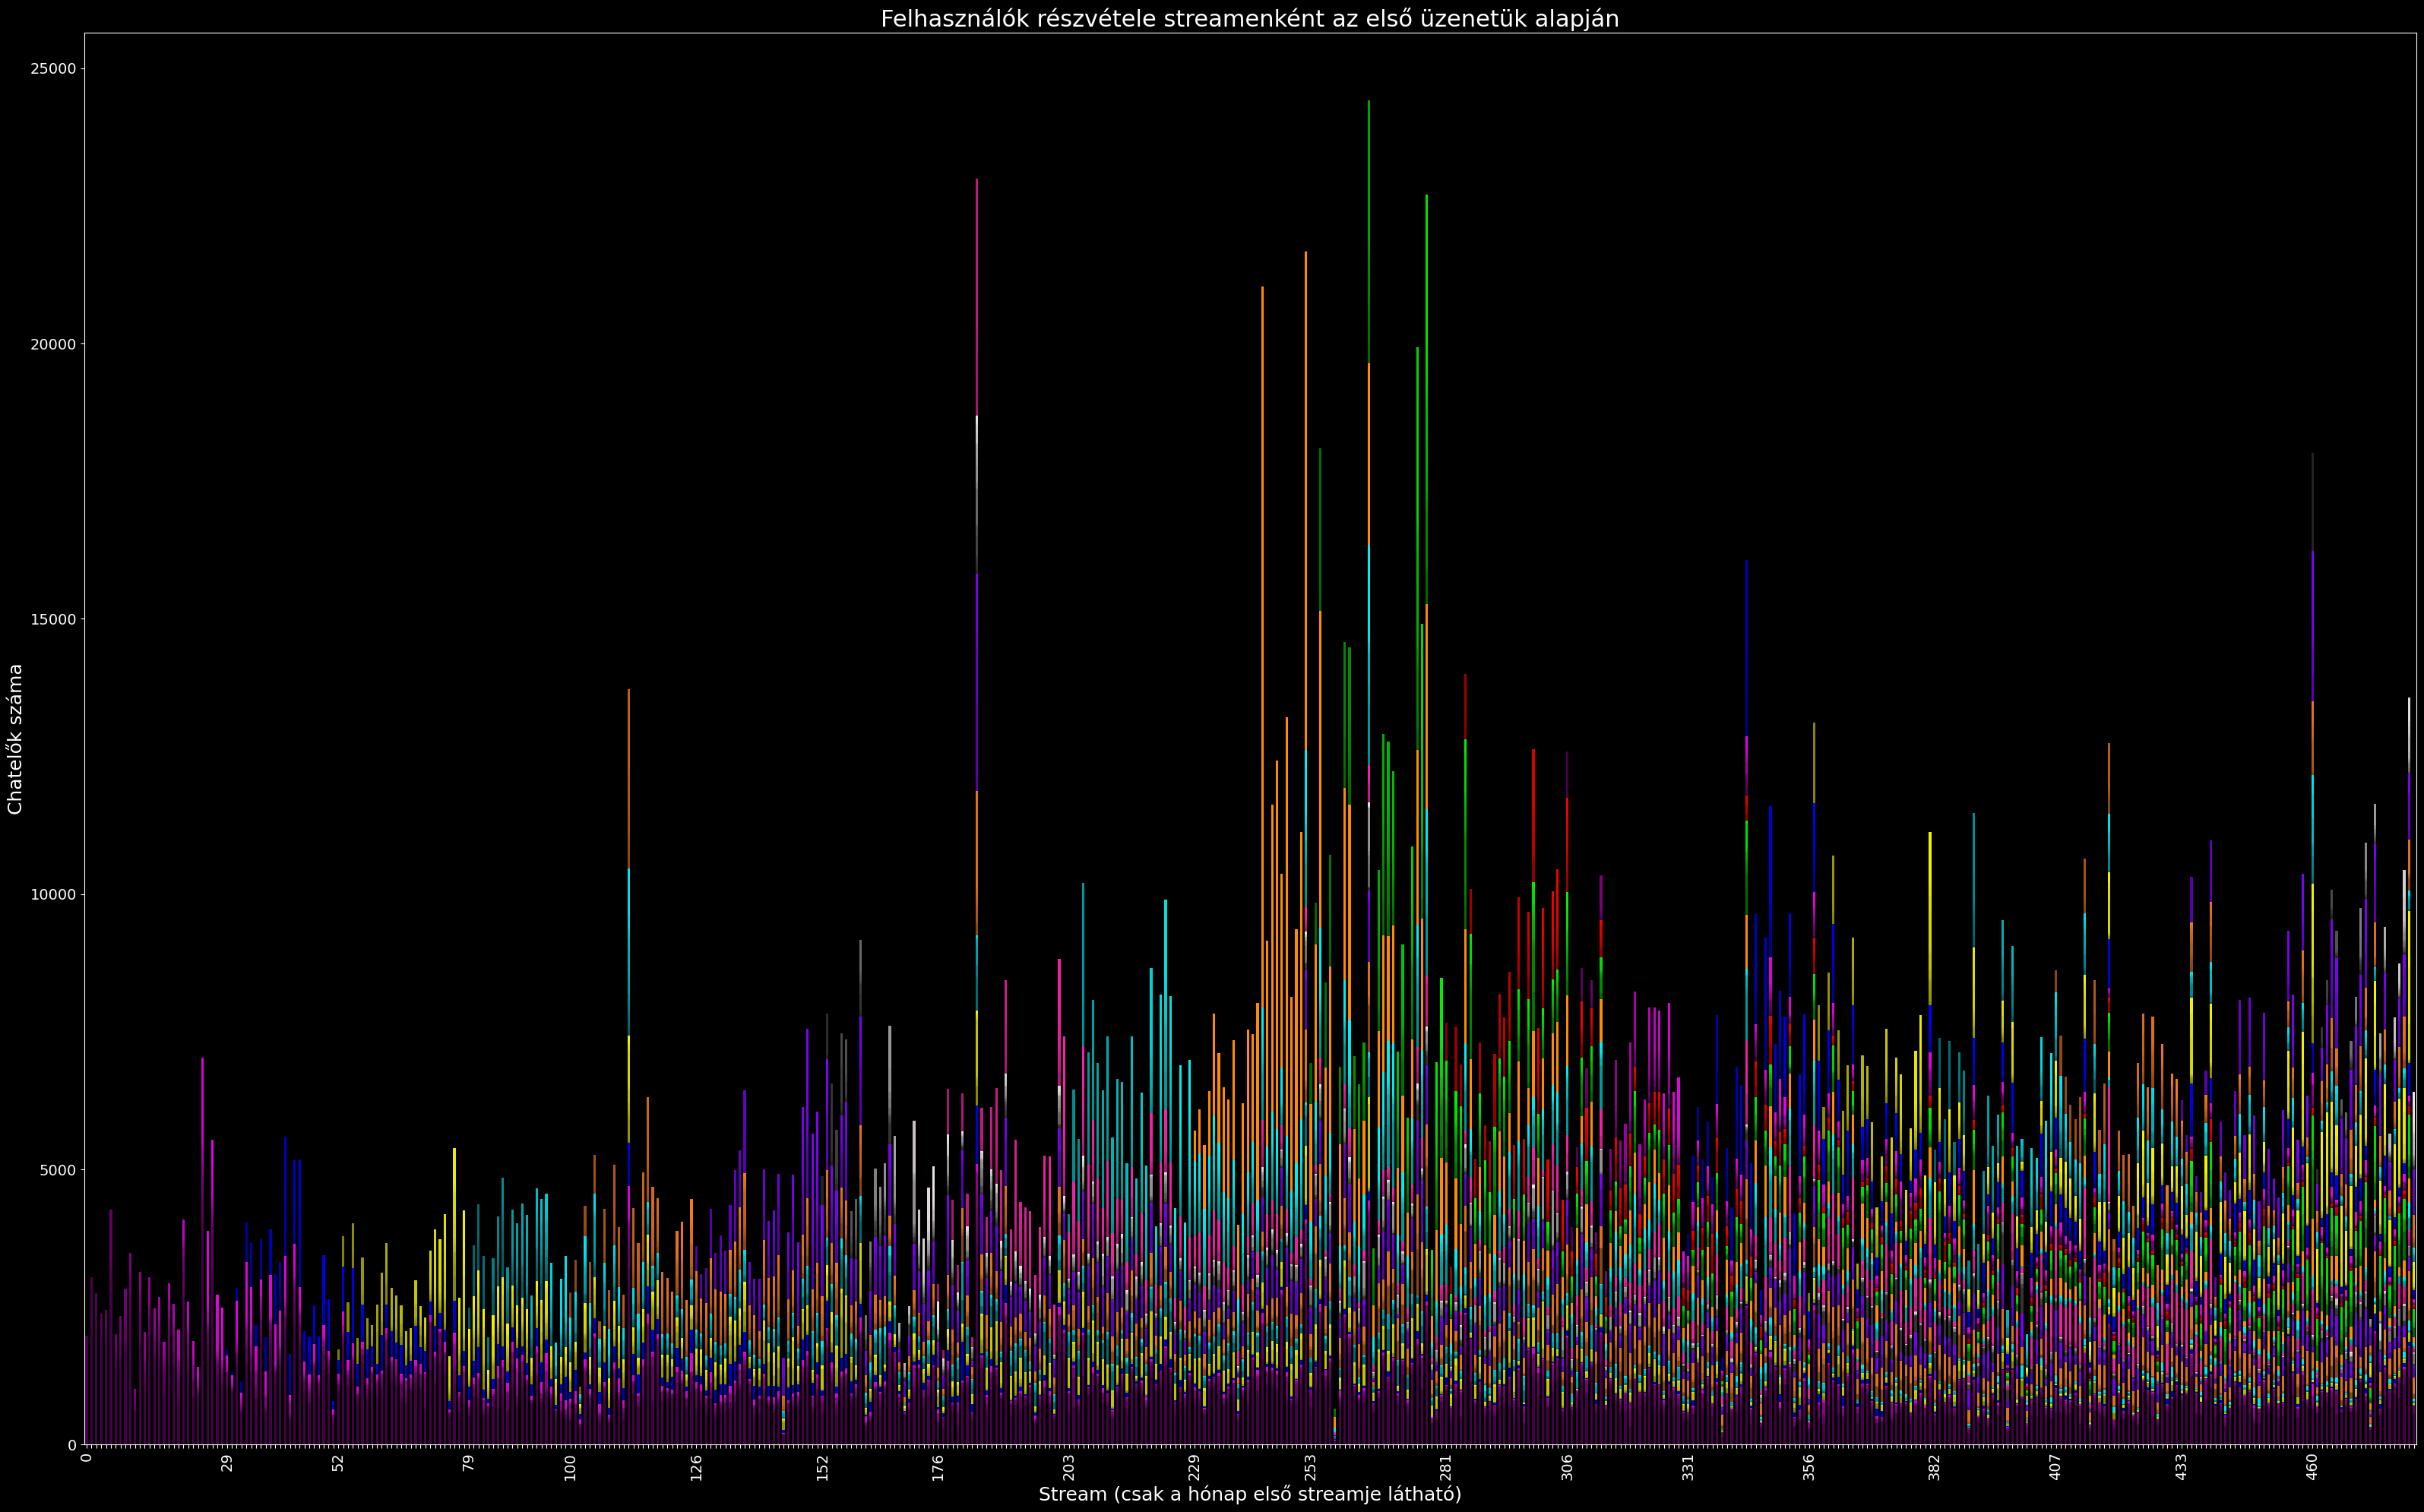

In [12]:

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(32, 20))

# Plot stacked bar chart - keep this as is
pivot_table.plot(kind='bar', stacked=True, ax=ax, color=sorted_color_list, legend=False)

# --- X-axis Label Modification Logic ---

# Get the streams in the order they appear on the plot
ordered_streams = pivot_table.index

# Get the corresponding start period (Year-Month) for each stream in plot order
# Use .reindex() to ensure alignment and handle potential missing streams gracefully
try:
    ordered_periods = stream_start_periods.reindex(ordered_streams)
except NameError:
    print("Error: 'stream_start_periods' not defined. Please run the prerequisite calculations.")
    # Optionally, provide default behavior or exit
    ordered_periods = pd.Series([None] * len(ordered_streams), index=ordered_streams) # Example fallback

# Generate the new list of labels
new_x_labels = []
last_period_shown = None

for stream, current_period in ordered_periods.items():
    # Handle streams that might not have a calculated period (e.g., not in original data)
    if pd.isna(current_period):
        # Decide how to handle streams missing period info - show label or hide?
        # Option 1: Hide label
        new_x_labels.append('')
        # Option 2: Show stream name anyway (uncomment below)
        # new_x_labels.append(stream)
        continue # Move to the next stream

    # Check if it's the first stream OR if the period (Year-Month) has changed
    if last_period_shown is None or current_period != last_period_shown:
        new_x_labels.append(stream)  # Show the stream name
        last_period_shown = current_period  # Update the last period we showed a label for
    else:
        new_x_labels.append('')  # Hide the label (same period as the previous one)

# Set the x-tick positions (0, 1, 2, ...) and the custom labels
tick_positions = range(len(ordered_streams))
ax.set_xticks(tick_positions)
ax.set_xticklabels(new_x_labels, rotation=90, fontsize=14, ha='center') # Apply new labels


# Set other plot elements
plt.title('Felhasználók részvétele streamenként az első üzenetük alapján', fontsize=22)
plt.xlabel('Stream (csak a hónap első streamje látható)', fontsize=18) # Modified label to explain
plt.ylabel('Chatelők száma', fontsize=18)

# Set y-axis font size (yticks was already done implicitly by set_xticklabels affecting both)
plt.yticks(fontsize=14)

# Optional: Add grid lines for better readability if needed
# ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [13]:
# Convert pivot table values to percentages (row-wise normalization)
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100


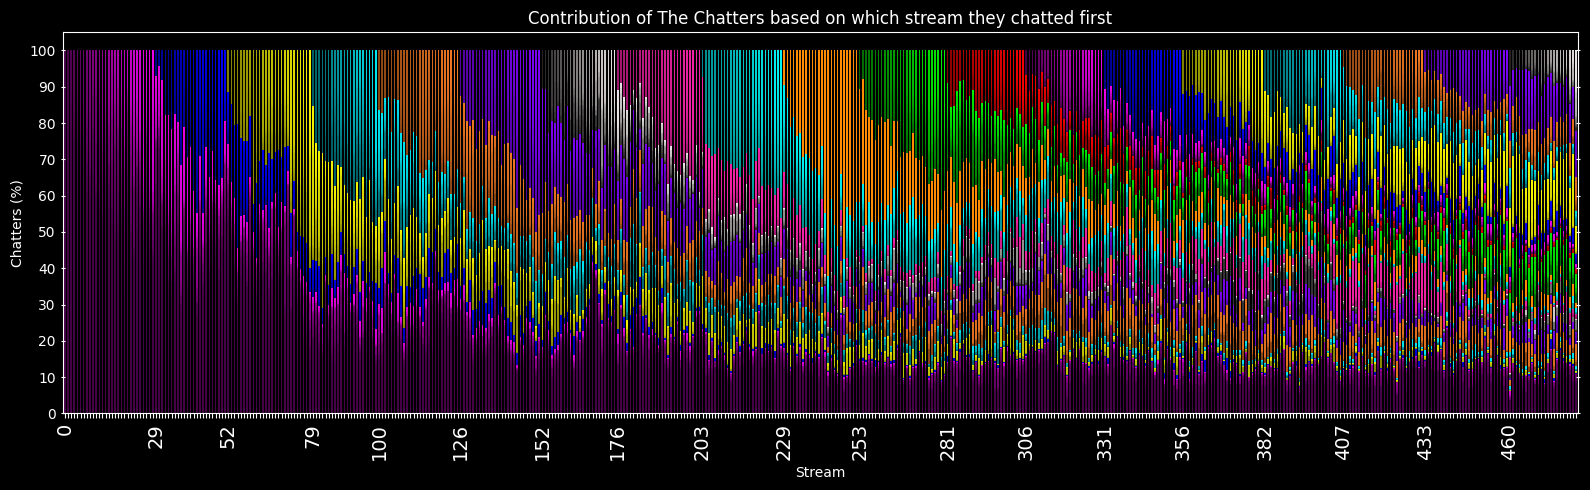

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the percentage data
plt.style.use('dark_background')
ax = pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(16, 5), color=sorted_color_list, legend=False)

plt.title('Contribution of The Chatters based on which stream they chatted first')

# Adjust x and y labels
plt.xlabel('Stream', fontsize=10)  # Make x-axis label smaller
plt.ylabel('Chatters (%)')

# Adjust y-axis ticks to show every 10
plt.yticks(np.arange(0, 101, 10))  

# Show y-axis ticks on both left and right
ax.yaxis.set_ticks_position('both')

# Set the x-tick positions (0, 1, 2, ...) and the custom labels
tick_positions = range(len(ordered_streams))
ax.set_xticks(tick_positions)
ax.set_xticklabels(new_x_labels, rotation=90, fontsize=14, ha='center') # Apply new labels

ax.tick_params(axis='y', direction='inout')

plt.tight_layout()
plt.show()

In [15]:
pivot_table_percentage

first_stream,0,1,2,3,4,5,6,7,8,9,...,472,473,474,475,476,477,478,479,480,481
0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,69.107026,30.892974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,78.068264,7.407407,14.524328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,75.284211,3.663158,4.336842,16.715789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,75.030550,3.543788,4.154786,3.258656,14.012220,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,10.731770,1.069312,0.012883,0.000000,0.000000,1.571760,0.000000,0.025767,0.399382,0.141716,...,0.270549,0.270549,0.618397,0.425148,0.618397,5.964957,0.000000,0.000000,0.000000,0.000000
478,9.621325,0.114403,0.000000,0.000000,0.000000,3.088891,0.068642,0.011440,0.411852,0.594898,...,0.011440,0.114403,0.205926,0.217366,0.755062,0.240247,3.946917,0.000000,0.000000,0.000000
479,10.075663,0.517192,0.076621,0.000000,0.000000,1.417489,0.009578,0.565080,0.028733,0.383105,...,0.354372,0.450148,0.162820,0.469304,0.632123,1.915525,2.059190,4.903745,0.000000,0.000000
480,8.949502,0.058975,0.044231,0.000000,0.000000,3.376336,0.000000,0.191670,0.044231,0.420199,...,0.051603,0.235901,0.169554,0.774051,2.049392,0.471802,1.061555,0.626613,3.074088,0.000000


In [16]:
#pivot_table.to_excel('your_excel_file.xlsx', sheet_name='Pivot Table')